# Notebbok for evaluating inter-annotator agreement

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import json
import random
from pprint import pprint
import re

from itertools import product, combinations
import importlib

from contextlib import redirect_stderr
import io
import sys
import os
import glob

from sklearn.metrics.pairwise import cosine_similarity
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from tqdm.auto import tqdm

AICOPE_PY_LIB = os.environ.get("AICOPE_PY_LIB")
if AICOPE_PY_LIB and AICOPE_PY_LIB not in sys.path: sys.path.append(AICOPE_PY_LIB)
import importlib
import aicnlp
importlib.reload(aicnlp)

%config Completer.use_jedi = False
PACSIM_DATA = os.environ.get("AICOPE_SCRATCH") + "/pacsim"

In [2]:
from aicnlp import emb_mgr
importlib.reload(emb_mgr)

mgr = emb_mgr.EmbMgr("/workspace/scratch/pacsim/mgrdata")

In [3]:
from aicnlp.validation.agreement import extract_annotations
importlib.reload(aicnlp.validation.agreement)
from aicnlp.validation.agreement import extract_annotations

with open("/home/ubuntu/petr/similarity/validace/evaluation-response-20220907.json", encoding='utf-8') as f:
    valdata = json.load(f)
    
annotations, mean_annotations = extract_annotations(valdata)

In [10]:
def get_agreement_batch(batch):
    # batch=batch.reset_index(drop=True)
    # print(batch)
    anns = batch["ann"].unique()
    cors = []
    for a1, a2 in combinations(anns, 2):
        s1 = batch[batch["ann"] == a1].sort_values("proxy")
        s2 = batch[batch["ann"] == a2].sort_values("proxy")
        c, p = stats.kendalltau(s1["value"], s2["value"])
        cors.append({"vs": f"{a1}-{a2}", "value": c, "pval": p})

    return pd.DataFrame.from_records(cors)


def get_agreement(annotations):
    return annotations.groupby(["pivot", "cat"]).apply(get_agreement_batch).reset_index().drop(columns=["level_2"])


In [11]:
with redirect_stderr(io.StringIO()) as f:
    agreement = get_agreement(annotations)
agreement

,pivot,cat,vs,value,pval
0,102913,01,a3-a4,0.400000,0.483333
1,102913,01,a3-a6,0.600000,0.233333
2,102913,01,a4-a6,0.800000,0.083333
3,102913,02,a3-a4,0.888889,0.037356
4,102913,02,a3-a6,-0.316228,0.448489
...,...,...,...,...,...
295,80561,09,a3-a6,0.316228,0.448489
296,80561,09,a4-a6,0.816497,0.075561
297,80561,10,a3-a4,0.200000,0.816667
298,80561,10,a3-a6,-0.358569,0.405381


In [12]:
catnames = { 
    "01": "01\nAge",
    "02": "02\nFamily\nhistory",
    "03": "03\nMedical\nhistory",
    "04": "04\nSocial\nhistory",
    "05": "05\nMedication",
    "06": "06\nAllergies",
    "07": "07\nTumor",
    "08": "08\nTreatment",
    "09": "09\nTreatment\ntype",
    "10": "10\nSide\neffects",
}

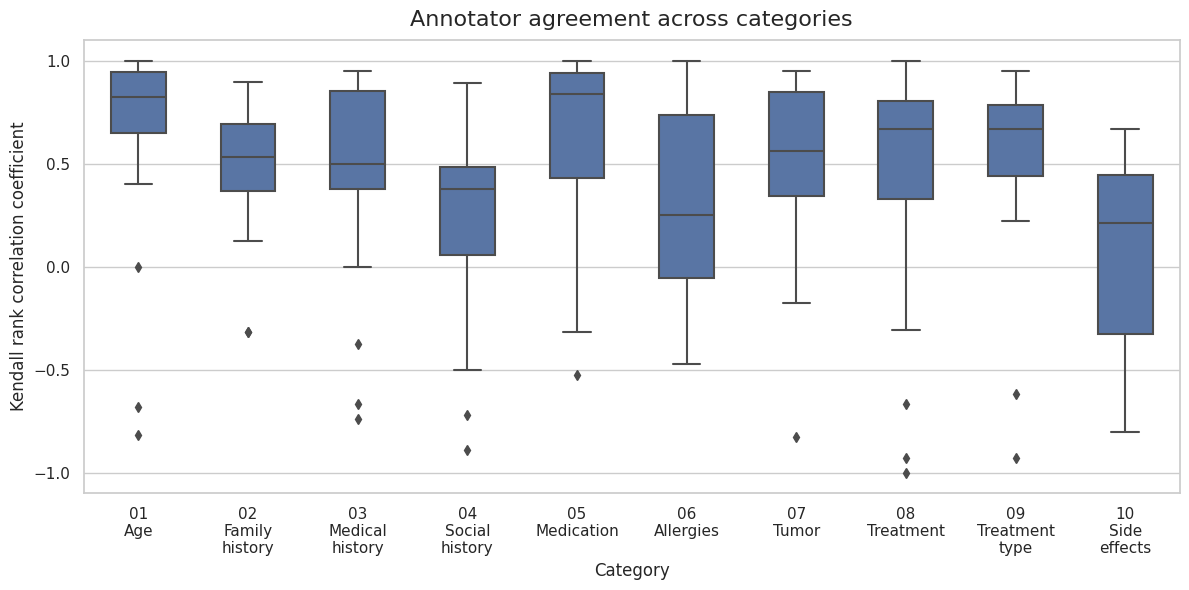

In [17]:
def agr_scatter(agreement, x="cat", title="Annotator agreement across categories"):
    agreement = agreement.copy()
    agreement["cat"] = agreement["cat"].map(catnames)
    # rdict = {"cat": "Category", "value": "Spearman correlation"}
    # agreement = agreement.rename(columns=rdict)
    
    sns.set_theme(style="whitegrid", rc={'figure.figsize':(12, 6), 'axes.titlepad': 10})
    fig, ax = plt.subplots()
    with sns.axes_style("whitegrid"):
        plot = sns.boxplot(agreement, x=x, y="value", palette=["C0"], width=0.5, ax=ax)
    plot.set(ylim=(-1.1,1.1),)
    plot.set_xlabel("Category")
    plot.set_ylabel("Kendall rank correlation coefficient")
    plot.tick_params(axis="x", labelsize=11)
    plot.set(yticks=[-1, -0.5, 0, 0.5, 1])
    plot.set_title(title, fontsize=16)
    sns.reset_orig()
    return fig, plot

fig, plot = agr_scatter(agreement)
plt.tight_layout()
fig.savefig(f"{PACSIM_DATA}/simvis/agreement.pdf")
plt.show(fig)
plt.close(fig)

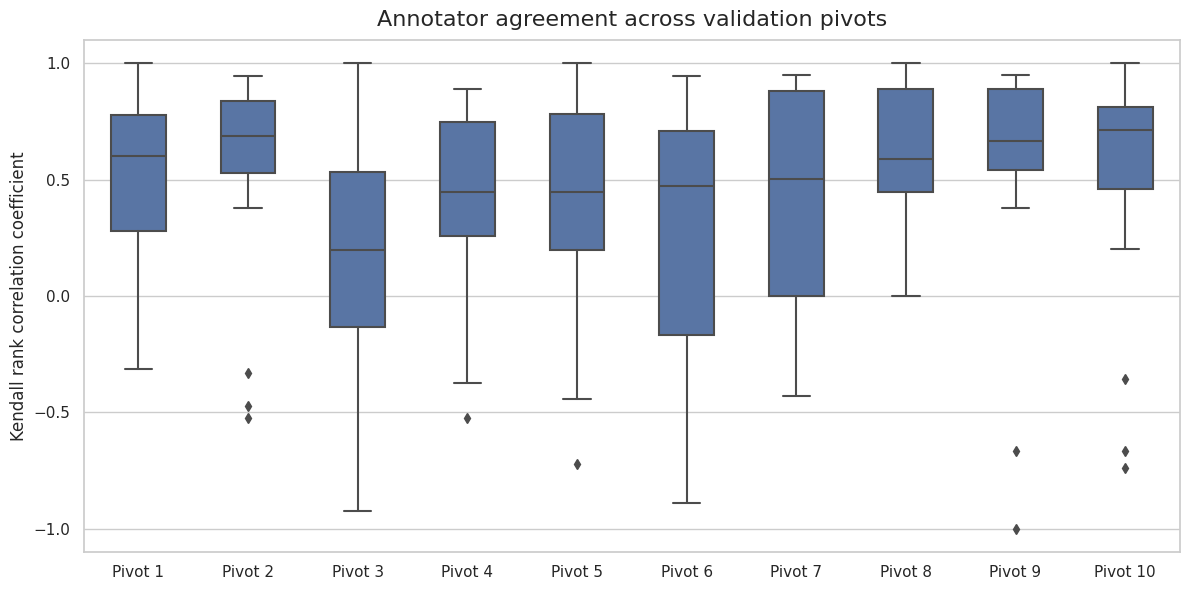

In [25]:
fig, plot = agr_scatter(agreement, x="pivot", title="Annotator agreement across validation pivots")
plot.set_xticklabels([f"Pivot {i}" for i in range(1,11)])
plot.set_xlabel(None)
plt.tight_layout()
fig.savefig(f"{PACSIM_DATA}/simvis/agreement-pivots.pdf")
plt.show(fig)
plt.close(fig)